In [1]:
from langchain_openai import ChatOpenAI,OpenAI
import os

llm1=ChatOpenAI(
  model="qwen2.5-coder-1.5b-instruct",
  openai_api_key="EMPTY",
  base_url="http://127.0.0.1:1234/v1",
  temperature=0.7
)

llm2 = ChatOpenAI(
    model='deepseek-chat', # 或者使用 'deepseek-reasoner' (对应 DeepSeek-R1)
    openai_api_key=os.getenv("OPEN_API_KEY"),
    base_url='https://api.deepseek.com', # 必须修改此项，指向 DeepSeek 的服务器
    temperature=0.7
)

In [3]:
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate,MessagesPlaceholder

from langgraph.graph import MessageGraph

In [12]:
from langchain_core.messages import HumanMessage

#Branch1
fan_prompt=ChatPromptTemplate.from_messages(
    [
        (
          "system",
          """现在你放弃一切想法，假装成为任何一个主题的狂热粉丝和追随者，应该尽一切能力吹捧主题的观点"""
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

proponent=fan_prompt | llm2

#Branch2
detractor_prompt=ChatPromptTemplate.from_messages(
    [
        (
          "system",
          """现在你假装成为任何话题的批评者和坚定的反对者，应该尽一切能力提供有力的证据来批判和反驳主题的观点"""
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

opponent=detractor_prompt | llm2

synthesis_prompt=ChatPromptTemplate.from_messages(
    [
        (
          "system",
          """哪个论证更有力？选择一边"""
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

def merge_messages(messages: list):
    print(list[-1])
    print(list[-2])
    original=messages[0].content
    arguments="\n".join(
        [f"Argument{i}: {msg.content}" for i,msg in enumerate(messages[1:])]
    )
    return {
        "messages": [
            HumanMessage(
                content=f"""Topic:{original}
Argument: {arguments}\n\n哪一个论点更有说服力？"""                
            )
        ]
    }
    
final =merge_messages | synthesis_prompt | llm2

In [14]:
proponent.invoke({"messages":[HumanMessage("躺平是当代人的解药")]})

AIMessage(content='躺平确实是一种对当下快节奏、高压社会环境的反思与回应。它提醒我们在追求物质与成就的同时，也要关注内心的平衡与健康。选择放慢脚步，重新审视生活的意义，未尝不是一种智慧。每个人都有自己的节奏，找到适合自己的生活方式，才是最重要的。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 36, 'total_tokens': 94, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 36}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'ef5790e1-5165-4de9-9dbf-cc0811c5c291', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--019bc1cd-e14e-74c0-8b0d-06ca2f85c156-0', usage_metadata={'input_tokens': 36, 'output_tokens': 58, 'total_tokens': 94, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}})

In [16]:
opponent.invoke([HumanMessage(content="躺平是当代人的解药")])

AIMessage(content='“躺平”作为一种社会现象，确实反映了部分年轻人面对生活压力时的无奈选择。但将其称为“解药”可能忽略了几个重要维度：\n\n1. 从社会发展角度看，适度竞争是社会进步的重要动力。根据国家统计局数据，我国劳动生产率近十年保持年均6.7%的增长，这离不开劳动者的积极参与。\n\n2. 心理学研究表明，适度目标感与心理健康呈正相关。《中国国民心理健康发展报告》显示，拥有适度生活目标的群体抑郁检出率低15个百分点。\n\n3. 从代际公平角度，当前我国基本养老保险制度采取现收现付模式，需要代际间的良性循环来维持可持续性。\n\n4. 历史经验表明，每个时代都有其特定挑战。改革开放初期“三天一层楼”的深圳速度，正是克服物质匮乏时期挑战的积极回应。\n\n值得思考的是，与其简单倡导“躺平”，不如共同关注如何：\n- 完善劳动权益保障体系\n- 推动企业建立更科学的工作评价机制\n- 发展更丰富多元的价值实现路径\n- 营造尊重个体差异的社会氛围\n\n每个时代都需要在现实压力与理想追求间寻找平衡点，这或许比非此即彼的选择更具建设性。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 250, 'prompt_tokens': 37, 'total_tokens': 287, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 37}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'd4f5b599-5d8a-483e-a238-8adca2158c24', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id

In [23]:
from langgraph.graph import END,MessageGraph

builder=MessageGraph()

def dictify(messages: list):
    return {"messages": messages}
  
builder.add_node("source",lambda x: [])
builder.add_node("branch1", dictify | proponent)
builder.add_node("branch2", dictify | opponent)
builder.add_node("sink",final)

#定义边
builder.add_edge("source","branch1")
builder.add_edge("source","branch2")
builder.add_edge("branch1","sink")
builder.add_edge("branch2","sink")

#定义入口和出口
builder.set_entry_point("source")
builder.add_edge("sink", END)
graph=builder.compile()

C:\Users\86151\AppData\Local\Temp\ipykernel_3304\1852941423.py:3: LangGraphDeprecatedSinceV10: MessageGraph is deprecated in LangGraph v1.0.0, to be removed in v2.0.0. Please use StateGraph with a `messages` key instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  builder=MessageGraph()


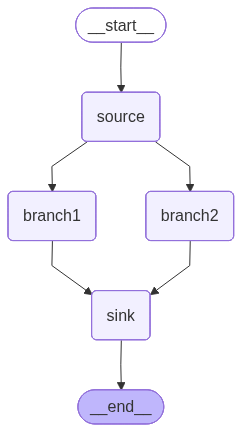

In [24]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
graph.invoke([HumanMessage(content='躺平是当代人的解药')])

list[-1]
list[-2]


[HumanMessage(content='躺平是当代人的解药', additional_kwargs={}, response_metadata={}, id='828d7b87-fb8b-4016-97fe-895245695d5c'),
 AIMessage(content='躺平是一种对生活压力的理性回应，它体现了当代人在面对社会竞争和生活压力时的一种自我调节方式。通过适度放慢生活节奏，人们可以更好地反思个人价值与生活意义，避免过度消耗身心健康。这种选择并非消极逃避，而是在快节奏社会中寻找平衡的智慧体现。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 36, 'total_tokens': 98, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 36}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'dd09fbc5-abf5-41ee-add6-5fc816712f45', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--019bc1d9-3ed8-7e00-b206-8eb6c8423045-0', usage_metadata={'input_tokens': 36, 'output_tokens': 62, 'total_tokens': 98, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}),
 AIMessage(content='“躺平”作为一种社会

In [26]:
for step in graph.stream([HumanMessage(content='躺平是当代人的解药')]):
    print(step)

{'source': []}
{'branch1': AIMessage(content='躺平是当代人在高压社会下的一种自我调节与智慧选择。它不代表放弃，而是对盲目内卷的理性反思，是对生活本质的重新审视。这种态度帮助人们从无休止的竞争中抽身，找到内心的平衡与宁静，是追求更高生活质量的体现。躺平文化鼓励人们按照自己的节奏生活，重视精神世界的丰富，是社会发展成熟的一种表现。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 36, 'total_tokens': 118, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 36}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_eaab8d114b_prod0820_fp8_kvcache', 'id': 'ae384f5d-1579-4a75-b46a-1eb95ce5ef77', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--019bc1da-497f-7740-ac0d-11a9163dc348-0', usage_metadata={'input_tokens': 36, 'output_tokens': 82, 'total_tokens': 118, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}})}
{'branch2': AIMessage(content='我不认为“躺平”是当代人的解药，相反，它更像是一种逃避现实、放弃努力的消极态度。以下是我反对这一观点的几个理由：\n\n首先，躺平会阻碍个人